#### **Importing Necessary Libraries**

In [1]:
import csv
import math
import time
import warnings
import operator
import statistics
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import datetime
from scipy import stats
from IPython.display import display_html
from multiprocessing import Pool
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

In [13]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

#### **Loading IPL Validation Dataset**

In [2]:
df_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/validationData_2020_09_18_14_50_01.csv')
print(df_ads.shape)
print('\n')
print('\n')
print(list(df_ads.columns))
print('\n')
print('\n')
display(df_ads.head())

(30711, 193)




['TTR', 'TTR normal', 'actualRaw', 'predictedRaw', 'Dispatch_Location_34th', 'Dispatch_Location_ARL.', 'Dispatch_Location_ENGLISH', 'Dispatch_Location_MILL', 'Dispatch_Location_SOUTH', 'Weekend_flag_False', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday', 'ZONE_ZONE2', 'ZONE_ZONE3', 'ZONE_ZONE4', 'CITY_NAM_AVON', 'CITY_NAM_BEECH.GROVE', 'CITY_NAM_BROWNSBURG', 'CITY_NAM_CAMBY', 'CITY_NAM_CARMEL', 'CITY_NAM_CLOVERDALE', 'CITY_NAM_EMINENCE', 'CITY_NAM_GREENFIELD', 'CITY_NAM_GREENWOOD', 'CITY_NAM_INDIANAPOLIS', 'CITY_NAM_LAWRENCE', 'CITY_NAM_LEBANON', 'CITY_NAM_MARTINSVILLE', 'CITY_NAM_MC.CORDSVILLE', 'CITY_NAM_MCCORDSVILLE', 'CITY_NAM_MONROVIA', 'CITY_NAM_MOORESVILLE', 'CITY_NAM_NEW.PALESTINE', 'CITY_NAM_NO_CITY', 'CITY_NAM_PARAGON', 'CITY_NAM_PLAINFIELD', 'CITY_NAM_QUINCY', 'CITY_NAM_SOUTHPORT', 'CITY_NAM_STILESVILLE', 'CITY_NAM_WEST.NEWTON', 'CITY_NAM_WHITESTOWN', 'CITY_NAM_ZIONSVILLE', 'PRIORITY_VAL_5.0_False', 'PRIORITY_VAL_

TTR  TTR normal  actualRaw  predictedRaw  Dispatch_Location_34th  Dispatch_Location_ARL.  Dispatch_Location_ENGLISH  Dispatch_Location_MILL  Dispatch_Location_SOUTH  Weekend_flag_False  Weekday_Friday  Weekday_Monday  Weekday_Sunday  Weekday_Thursday  Weekday_Tuesday  ZONE_ZONE2  ZONE_ZONE3  ZONE_ZONE4  CITY_NAM_AVON  CITY_NAM_BEECH.GROVE  CITY_NAM_BROWNSBURG  CITY_NAM_CAMBY  CITY_NAM_CARMEL  CITY_NAM_CLOVERDALE  CITY_NAM_EMINENCE  CITY_NAM_GREENFIELD  CITY_NAM_GREENWOOD  CITY_NAM_INDIANAPOLIS  CITY_NAM_LAWRENCE  CITY_NAM_LEBANON  CITY_NAM_MARTINSVILLE  CITY_NAM_MC.CORDSVILLE  CITY_NAM_MCCORDSVILLE  CITY_NAM_MONROVIA  CITY_NAM_MOORESVILLE  CITY_NAM_NEW.PALESTINE  CITY_NAM_NO_CITY  CITY_NAM_PARAGON  CITY_NAM_PLAINFIELD  CITY_NAM_QUINCY  CITY_NAM_SOUTHPORT  CITY_NAM_STILESVILLE  CITY_NAM_WEST.NEWTON  CITY_NAM_WHITESTOWN  CITY_NAM_ZIONSVILLE  PRIORITY_VAL_5.0_False  PRIORITY_VAL_3.0_False  PRIORITY_VAL_2.0_False  PRIORITY_VAL_1.0_True  OH_OCCURN_FLG_False  RECLOSER_OCCURN_FLG_False  \
0 4.68      108.17     108.17         78.03                       0                       0                          0                       1                        0                   1               0               1               0                 0                0           0           0           1              0                     0                    0               0                0                    0                  0                    0                   0                      1                  0                 0                      0                       0                      0                  0                     0                       0                 0                 0                    0                0                   0                     0                     0                    0                    0                       1                       1                       1                      1                    1                          1   
1 4.17       64.67      64.67         52.45                       0                       0                          0                       1                        0                   1               0               1               0                 0                0           0           0           1              0                     0                    0               0                0                    0                  0                    0                   0                      1                  0                 0                      0                       0                      0                  0                     0                       0                 0                 0                    0                0                   0                     0                     0                    0                    0                       1                       1                       1                      1                    1                          1   
2 4.31       74.37      74.37        144.55                       0                       0                          0                       0                        0                   1               0               0               0                 0                1           0           0           0              0                     0                    0               0                0                    0                  0                    0                   0                      1                  0                 0                      0                       0                      0                  0                     0                       0                 0                 0                    0                0                   0                     0                     0                    0                    0                       1                       1                       1                      1                    1                          1   
3 4

In [3]:
df_ads['Error_Term'] = df_ads['actualRaw'] - df_ads['predictedRaw']

In [8]:
def add_customer_metrics(actual, predicted):
    customer = None
    if (actual > predicted):
        customer = 'dissatified'
    elif (actual < predicted):
        customer = 'satisfied'
    else :
        customer = 'delighted'
    
    return customer

In [9]:
df_ads['Customer_Metric'] = df_ads.apply(lambda row: add_customer_metrics(row['actualRaw'], row['predictedRaw']),axis=1)

In [10]:
df_ads['Customer_Metric'].unique()

array(['dissatified', 'satisfied'], dtype=object)

In [11]:
df_ads.head()

TTR  TTR normal  actualRaw  predictedRaw  Dispatch_Location_34th  Dispatch_Location_ARL.  Dispatch_Location_ENGLISH  Dispatch_Location_MILL  Dispatch_Location_SOUTH  Weekend_flag_False  Weekday_Friday  Weekday_Monday  Weekday_Sunday  Weekday_Thursday  Weekday_Tuesday  ZONE_ZONE2  ZONE_ZONE3  ZONE_ZONE4  CITY_NAM_AVON  CITY_NAM_BEECH.GROVE  CITY_NAM_BROWNSBURG  CITY_NAM_CAMBY  CITY_NAM_CARMEL  CITY_NAM_CLOVERDALE  CITY_NAM_EMINENCE  CITY_NAM_GREENFIELD  CITY_NAM_GREENWOOD  CITY_NAM_INDIANAPOLIS  CITY_NAM_LAWRENCE  CITY_NAM_LEBANON  CITY_NAM_MARTINSVILLE  CITY_NAM_MC.CORDSVILLE  CITY_NAM_MCCORDSVILLE  CITY_NAM_MONROVIA  CITY_NAM_MOORESVILLE  CITY_NAM_NEW.PALESTINE  CITY_NAM_NO_CITY  CITY_NAM_PARAGON  CITY_NAM_PLAINFIELD  CITY_NAM_QUINCY  CITY_NAM_SOUTHPORT  CITY_NAM_STILESVILLE  CITY_NAM_WEST.NEWTON  CITY_NAM_WHITESTOWN  CITY_NAM_ZIONSVILLE  PRIORITY_VAL_5.0_False  PRIORITY_VAL_3.0_False  PRIORITY_VAL_2.0_False  PRIORITY_VAL_1.0_True  OH_OCCURN_FLG_False  RECLOSER_OCCURN_FLG_False  \
0 4.68      108.17     108.17         78.03                       0                       0                          0                       1                        0                   1               0               1               0                 0                0           0           0           1              0                     0                    0               0                0                    0                  0                    0                   0                      1                  0                 0                      0                       0                      0                  0                     0                       0                 0                 0                    0                0                   0                     0                     0                    0                    0                       1                       1                       1                      1                    1                          1   
1 4.17       64.67      64.67         52.45                       0                       0                          0                       1                        0                   1               0               1               0                 0                0           0           0           1              0                     0                    0               0                0                    0                  0                    0                   0                      1                  0                 0                      0                       0                      0                  0                     0                       0                 0                 0                    0                0                   0                     0                     0                    0                    0                       1                       1                       1                      1                    1                          1   
2 4.31       74.37      74.37        144.55                       0                       0                          0                       0                        0                   1               0               0               0                 0                1           0           0           0              0                     0                    0               0                0                    0                  0                    0                   0                      1                  0                 0                      0                       0                      0                  0                     0                       0                 0                 0                    0                0                   0                     0                     0                    0                    0                       1                       1                       1                      1                    1                          1   
3 4

In [12]:
df_ads.to_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/Test_Classification_Dataset_09212020.csv')

#### **Is the error term normally distributed ?**

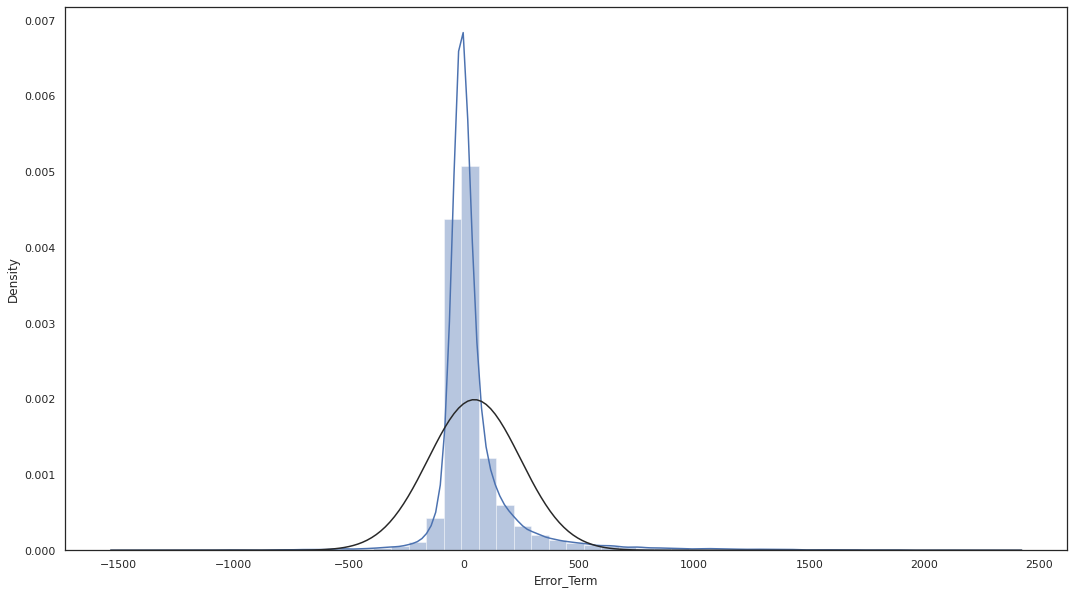

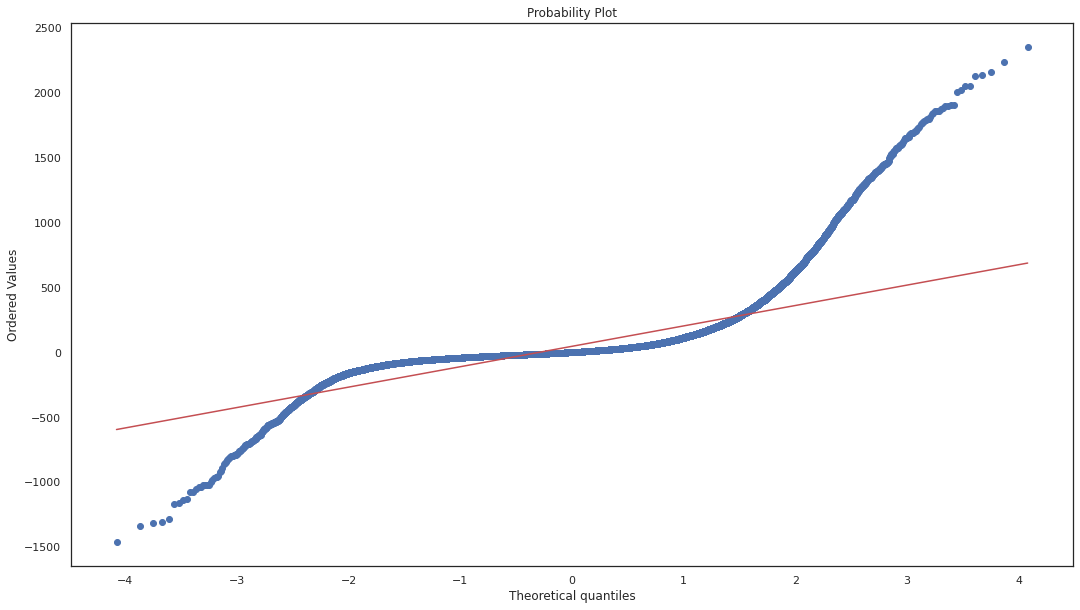

In [4]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(df_ads['Error_Term'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(df_ads['Error_Term'], plot=plt)

#### **Actual vs Fitted Plot for RF Model**

Text(0.5, 1.0, 'Actual vs Fitted : Random Forest Model')

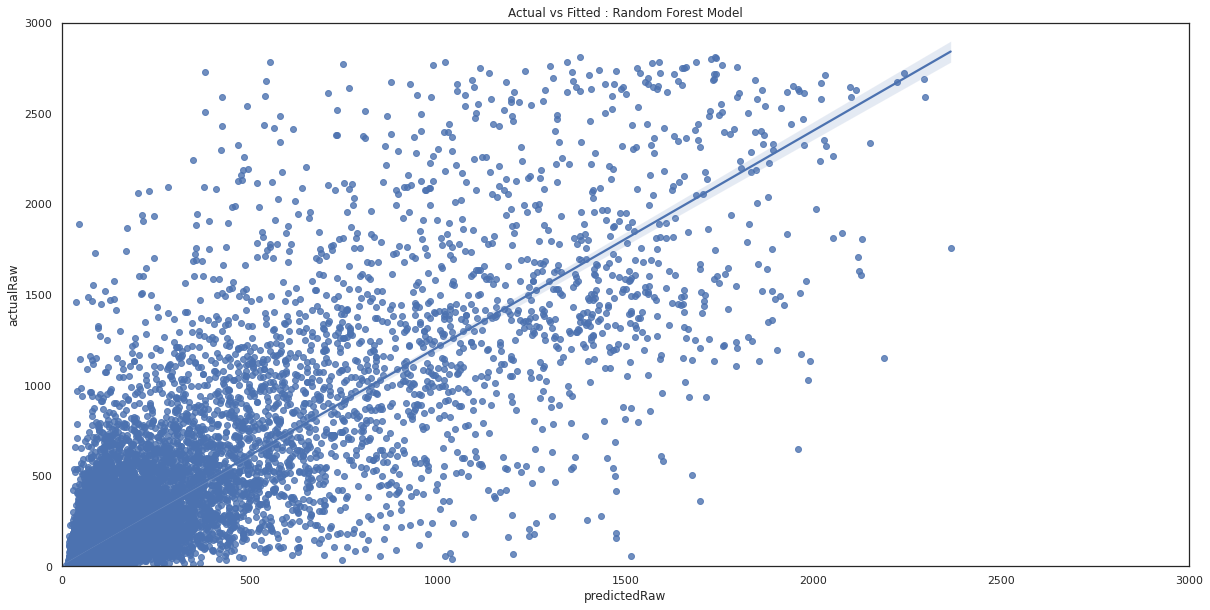

In [5]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.regplot(x="predictedRaw", y="actualRaw", data=df_ads)
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest Model')

#### **Plot for Customer Metrics**

In [6]:
def segment(x):
    if(x<=120):
        return "0-120"
    elif(x<=240):
        return "120-240"
    elif(x<=360):
        return "240-360"
    elif(x<=480):
        return "360-480"
    elif(x<=600):
        return "480-600"
    elif(x<=700):
        return "600-720"
    else:
        return ">720"
    
    
df_ads['Actual_segment'] = df_ads['actualRaw'].apply(segment)
df_ads['Prediction_segment'] = df_ads['predictedRaw'].apply(segment)

business_KPI = df_ads[['Actual_segment','Prediction_segment']]

# business_KPI['Actual_segment'] = pd.Categorical(business_KPI['Actual_segment'], ['0-120', '120-240', '240-360', '360-480', '480-600', '600-720', '>720'])

# business_KPI['Prediction_segment'] = pd.Categorical(business_KPI['Prediction_segment'], ['0-120', '120-240', '240-360', '360-480', '480-600', '600-720', '>720'])

#conversion to percentage
business_KPI = pd.pivot_table(business_KPI, index='Actual_segment',columns=['Prediction_segment'], values='Actual_segment', aggfunc=lambda x: len(x))
business_KPI["total"] =  business_KPI.sum(axis=1)
business_KPI.columns.name = 'Predicted_Values'
business_KPI.index.name = 'Actual_Values'

# Add the grand total row, summing all values in a column
business_KPI.loc['total', :] = business_KPI.sum()

In [7]:
def style_diag(data):
    diag_mask = pd.DataFrame("", index=data.index, columns=data.columns)
    min_axis = min(diag_mask.shape)
    diag_mask.iloc[range(min_axis), range(min_axis)] = 'background-color:#aed581'
    return diag_mask

In [8]:
business_KPI = business_KPI.round(0)
df_percentage = np.round(business_KPI*100/business_KPI.iloc[-1, -1], 1)
df_percentage

Predicted_Values  0-120  120-240  240-360  360-480  480-600  600-720  >720  total
Actual_Values                                                                    
0-120             56.60     6.00     0.40     0.10     0.00     0.00  0.00  63.20
120-240           10.60     5.70     0.90     0.20     0.10     0.00  0.10  17.60
240-360            2.40     2.90     0.80     0.30     0.10     0.10  0.10   6.70
360-480            0.70     1.30     0.60     0.30     0.20     0.10  0.10   3.30
480-600            0.30     0.50     0.40     0.30     0.10     0.10  0.20   1.90
600-720            0.10     0.30     0.20     0.20     0.10     0.10  0.10   1.10
>720               0.20     0.40     0.50     0.60     0.70     0.40  3.50   6.30
total             70.90    17.10     3.90     1.90     1.30     0.70  4.10 100.00

In [9]:
df_percentage.style.apply(style_diag, axis=None)

#### **Outages with dissatisfied business metrics**

In [10]:
def flag_dissatified_outages(predicted, actual):
    dissatisfied_flag = 0
    
    if (((predicted == '0-120') & (actual == '120-240')) |
        ((predicted == '0-120') & (actual == '240-360')) |
        ((predicted == '0-120') & (actual == '360-480')) |
        ((predicted == '0-120') & (actual == '480-600')) |
        ((predicted == '0-120') & (actual == '600-720')) |
        ((predicted == '0-120') & (actual == '>720'))) :
        
        dissatisfied_flag = 1
    
    elif(((predicted == '120-240') & (actual == '240-360')) |
        ((predicted == '120-240') & (actual == '360-480')) |
        ((predicted == '120-240') & (actual == '480-600')) |
        ((predicted == '120-240') & (actual == '600-720')) |
        ((predicted == '120-240') & (actual == '>720'))) :
        
        dissatisfied_flag = 1
        
    elif(((predicted == '240-360') & (actual == '360-480')) |
        ((predicted == '240-360') & (actual == '480-600')) |
        ((predicted == '240-360') & (actual == '600-720')) |
        ((predicted == '240-360') & (actual == '>720'))) :
        
        dissatisfied_flag = 1
        
    elif(((predicted == '360-480') & (actual == '480-600')) |
        ((predicted == '360-480') & (actual == '600-720')) |
        ((predicted == '360-480') & (actual == '>720'))) :
        
        dissatisfied_flag = 1
        
    elif(((predicted == '480-600') & (actual == '600-720')) |
        ((predicted == '480-600') & (actual == '>720'))) :
        
        dissatisfied_flag = 1
        
    elif(((predicted == '600-720') & (actual == '>720'))) :
        
        dissatisfied_flag = 1        
    
    return dissatisfied_flag

In [11]:
df_ads['Dissatisfied'] = df_ads.apply(lambda row: flag_dissatified_outages(row['Prediction_segment'], row['Actual_segment']),axis=1)

In [12]:
df_copy = df_ads.copy(deep=True)
# df_copy = df_copy[df_copy.Dissatisfied == 1]
df_copy.reset_index(drop=True, inplace=True)

In [20]:
print(list(df_copy.columns))

['TTR', 'TTR normal', 'actualRaw', 'predictedRaw', 'Dispatch_Location_34th', 'Dispatch_Location_ARL.', 'Dispatch_Location_ENGLISH', 'Dispatch_Location_MILL', 'Dispatch_Location_SOUTH', 'Weekend_flag_False', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday', 'ZONE_ZONE2', 'ZONE_ZONE3', 'ZONE_ZONE4', 'CITY_NAM_AVON', 'CITY_NAM_BEECH.GROVE', 'CITY_NAM_BROWNSBURG', 'CITY_NAM_CAMBY', 'CITY_NAM_CARMEL', 'CITY_NAM_CLOVERDALE', 'CITY_NAM_EMINENCE', 'CITY_NAM_GREENFIELD', 'CITY_NAM_GREENWOOD', 'CITY_NAM_INDIANAPOLIS', 'CITY_NAM_LAWRENCE', 'CITY_NAM_LEBANON', 'CITY_NAM_MARTINSVILLE', 'CITY_NAM_MC.CORDSVILLE', 'CITY_NAM_MCCORDSVILLE', 'CITY_NAM_MONROVIA', 'CITY_NAM_MOORESVILLE', 'CITY_NAM_NEW.PALESTINE', 'CITY_NAM_NO_CITY', 'CITY_NAM_PARAGON', 'CITY_NAM_PLAINFIELD', 'CITY_NAM_QUINCY', 'CITY_NAM_SOUTHPORT', 'CITY_NAM_STILESVILLE', 'CITY_NAM_WEST.NEWTON', 'CITY_NAM_WHITESTOWN', 'CITY_NAM_ZIONSVILLE', 'PRIORITY_VAL_5.0_False', 'PRIORITY_VAL_3.0_False', 'PRIO

In [53]:
weather_features = ['cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg',
                    'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                    'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg',
                    'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg',
                    'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax', 'wetBulbMin',
                    'windChillAvg', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg', 'windSpd100mMax',
                    'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax',
                    'windSpdMin', 'relHumRatio', 'sfcPresRatio']

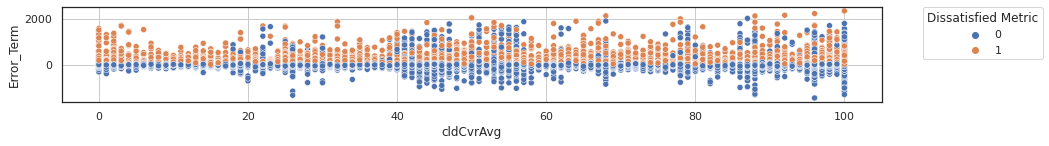

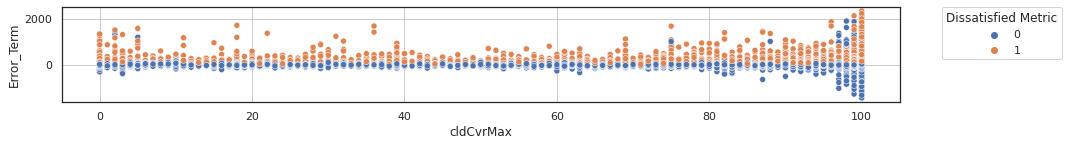

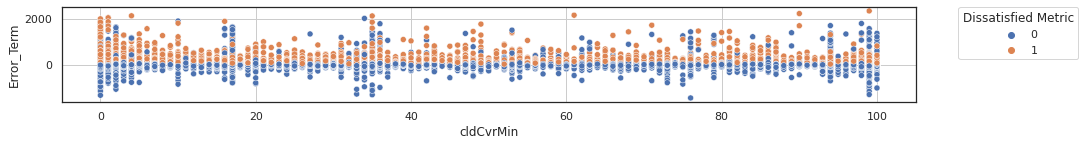

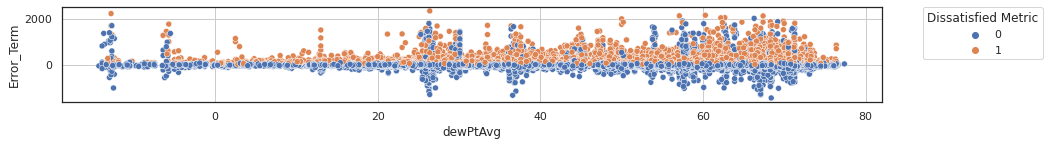

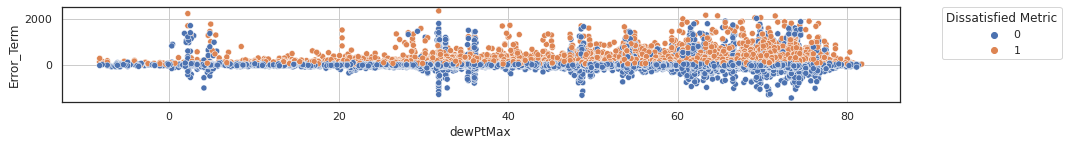

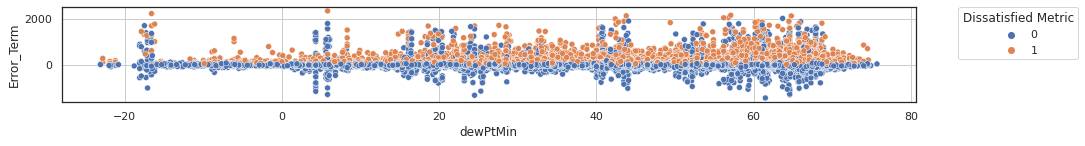

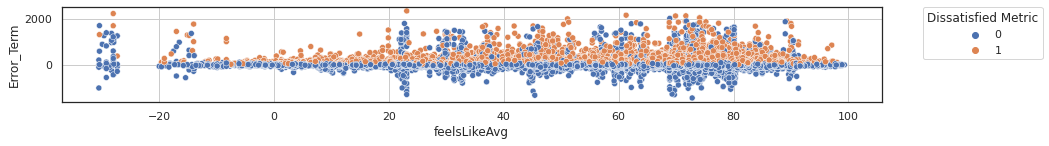

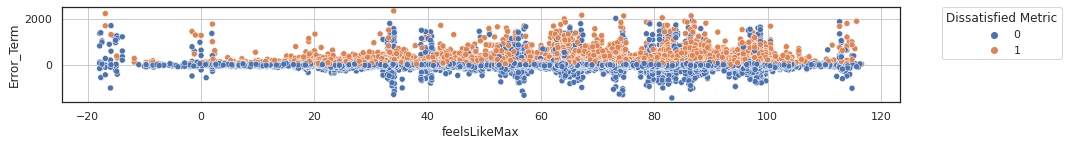

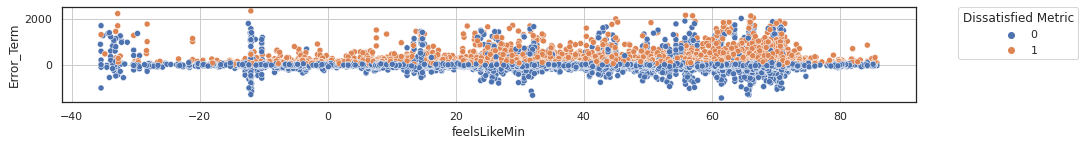

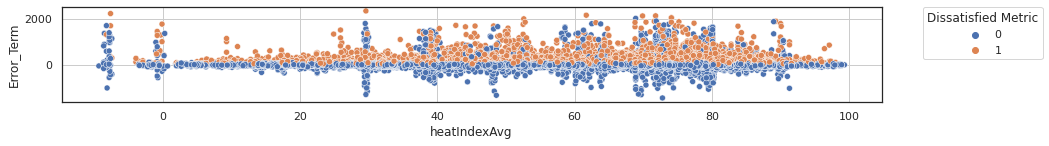

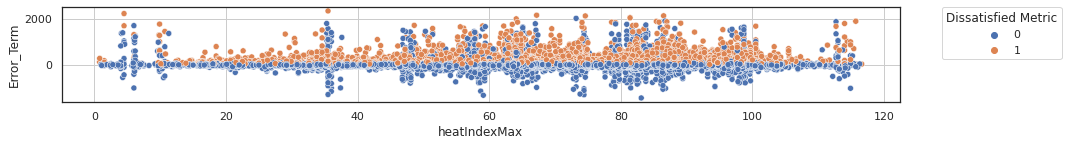

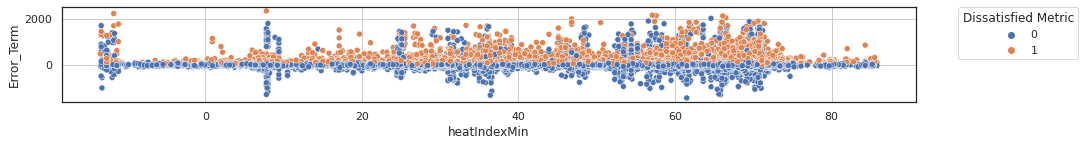

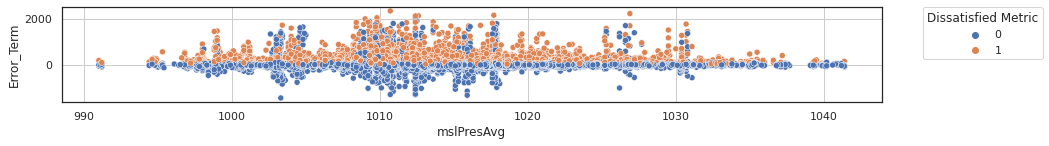

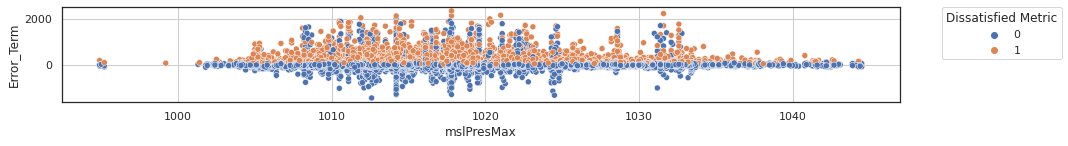

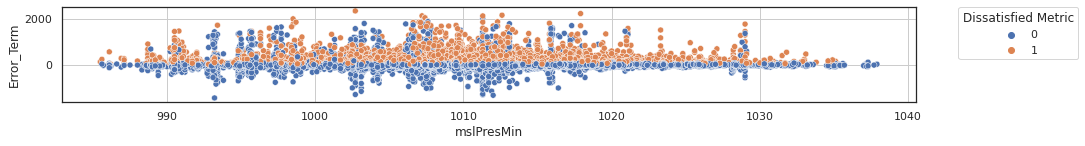

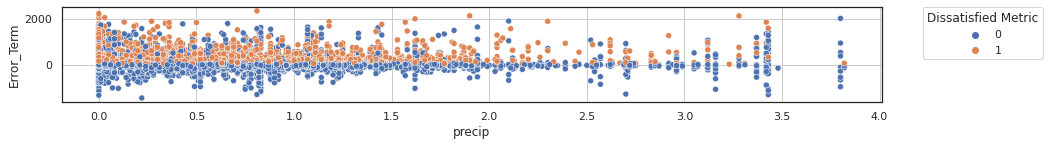

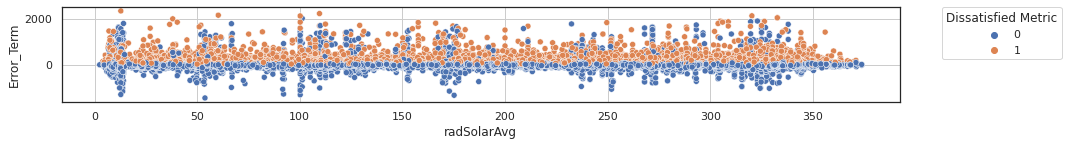

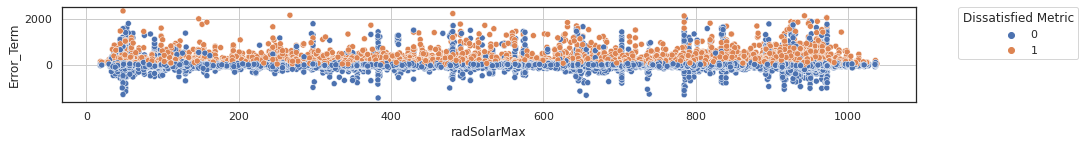

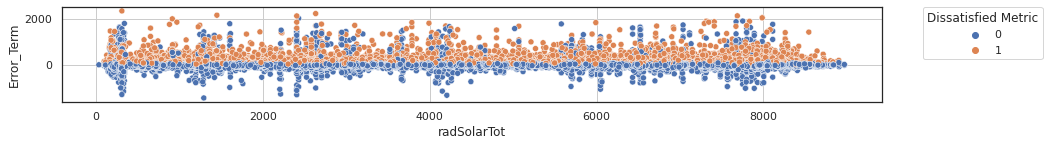

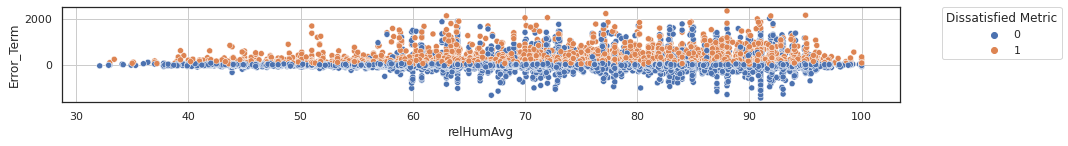

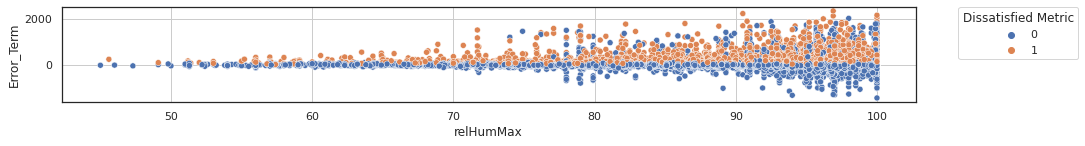

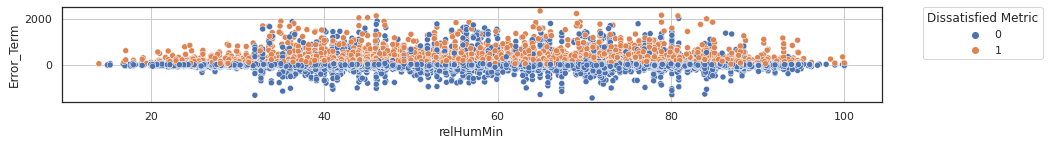

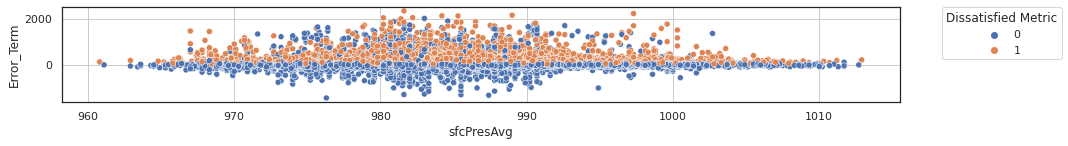

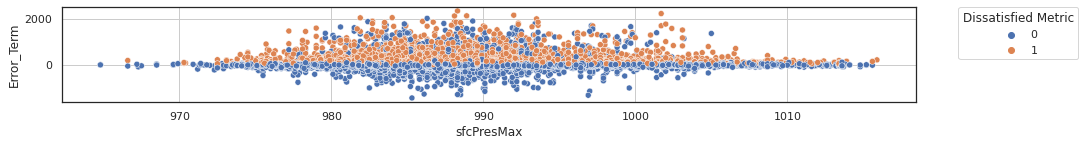

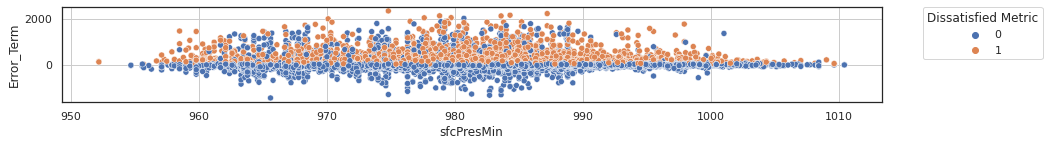

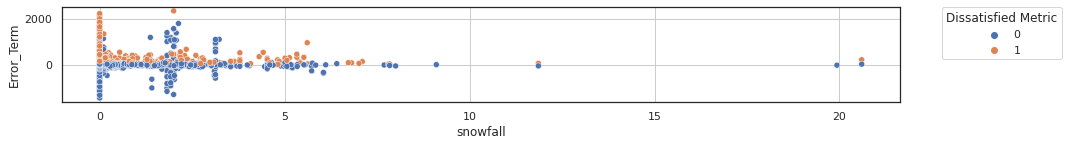

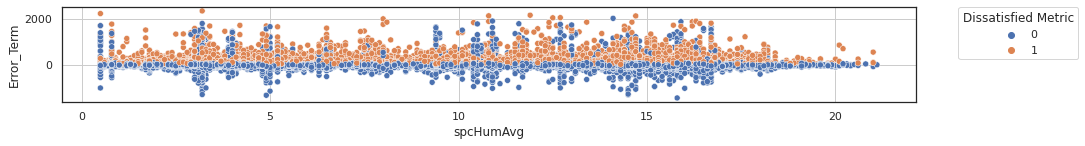

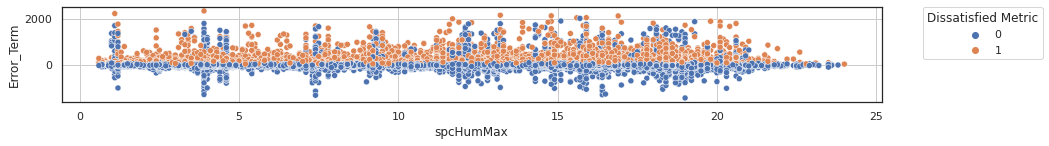

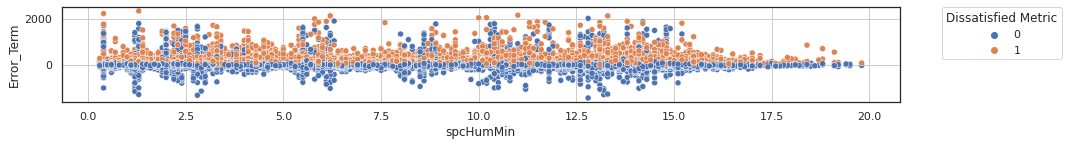

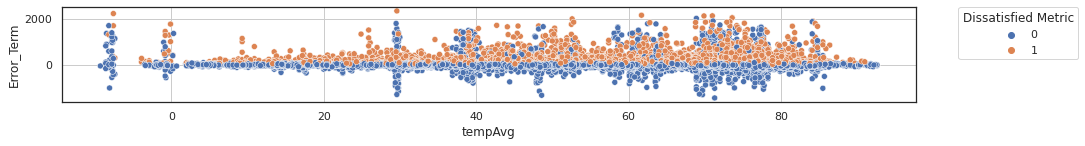

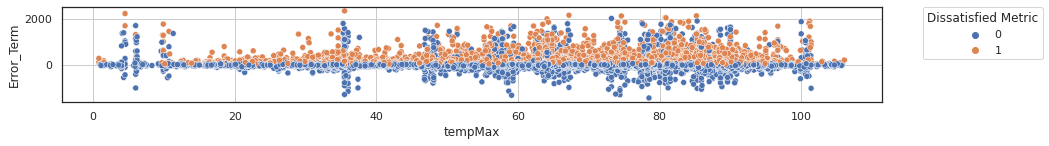

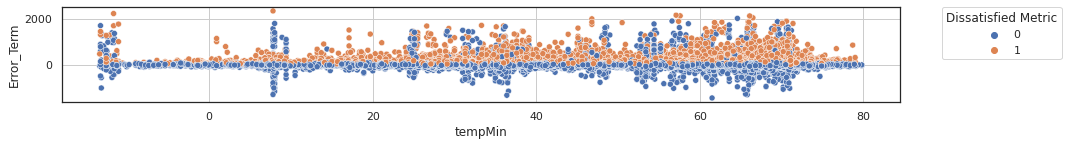

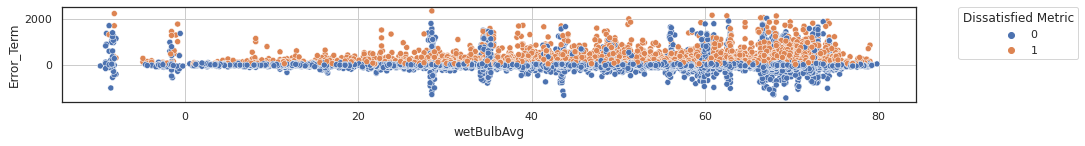

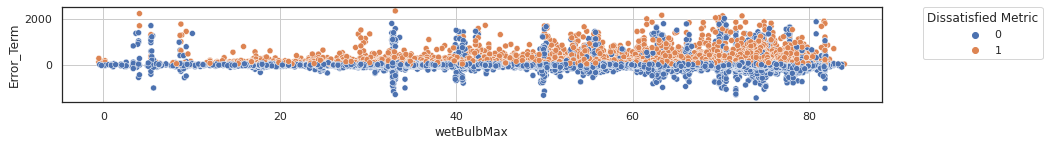

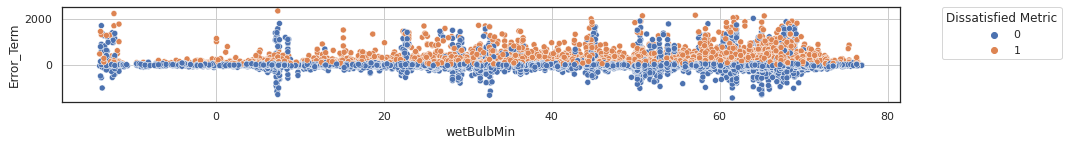

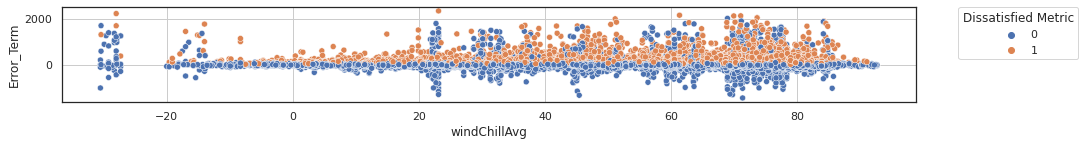

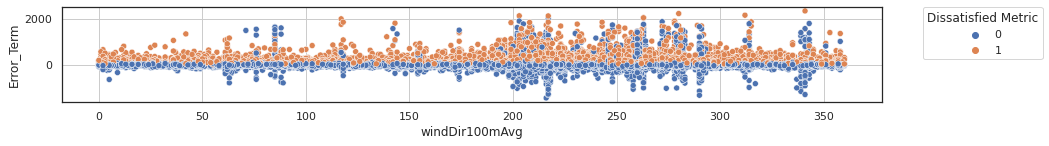

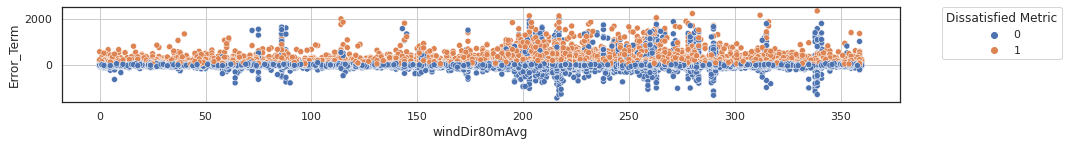

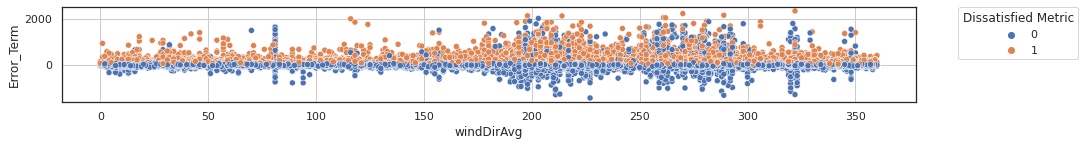

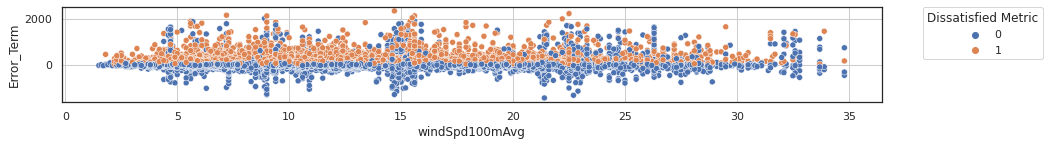

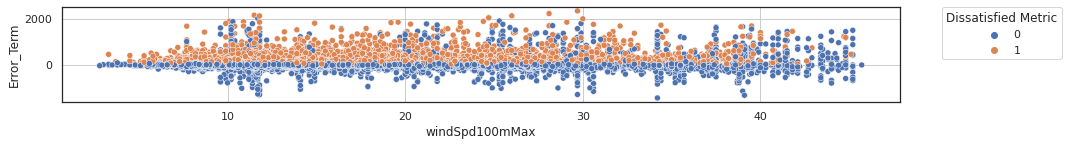

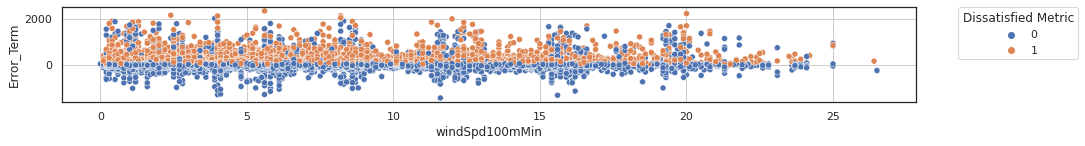

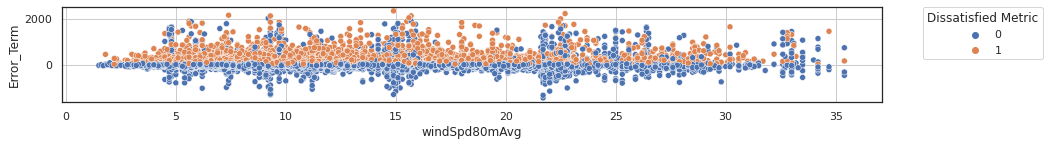

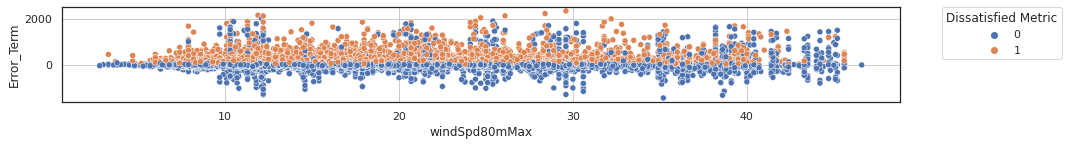

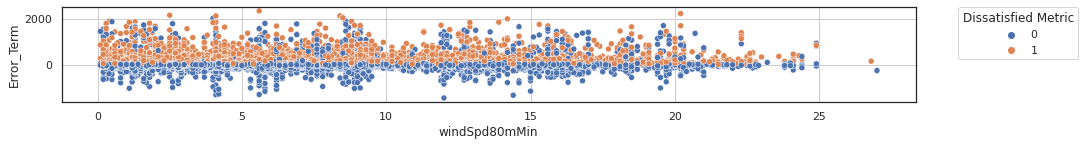

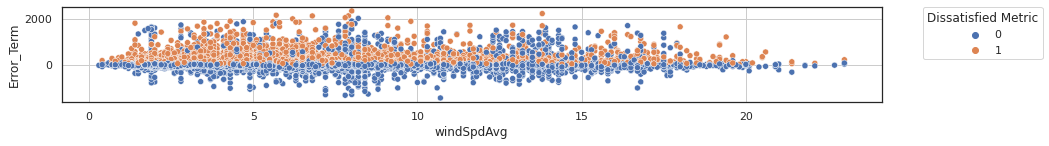

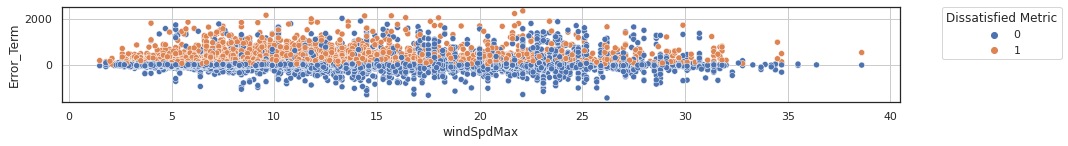

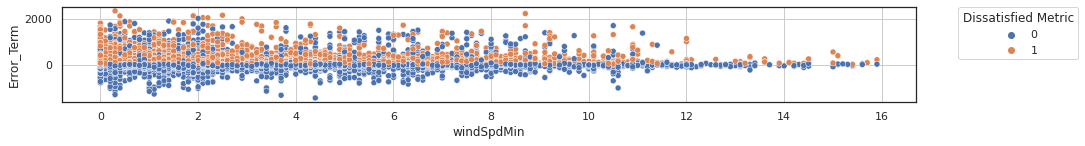

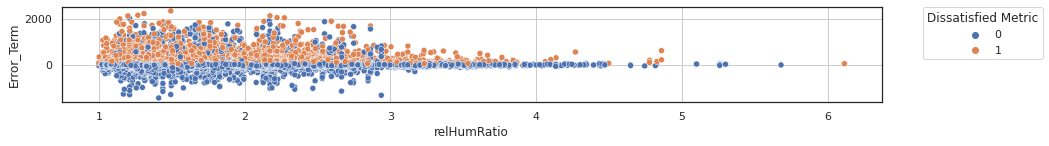

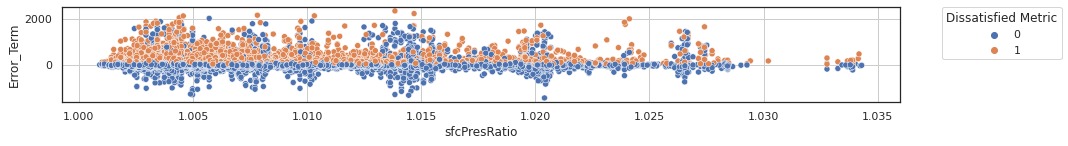

In [62]:
sns.set(rc={'figure.figsize':(40,40)})
sns.set_style("white")
for i, col in enumerate(list(df_copy[weather_features].columns.values)):
    plt.subplot(20,3,i+1)
    sns.scatterplot(data=df_copy, x=col, y="Error_Term", hue='Dissatisfied')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Dissatisfied Metric')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [50]:
day_cause_occurn_clue_features = ['NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY',
                                  'NO_OF_WIRE_OCCURN_PER_DAY', 'RANK_SUBSEQUENT_OUTAGES']

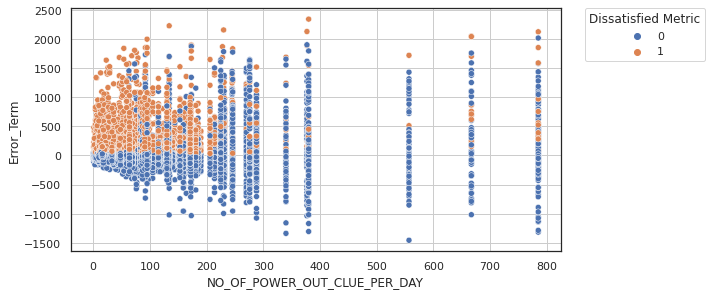

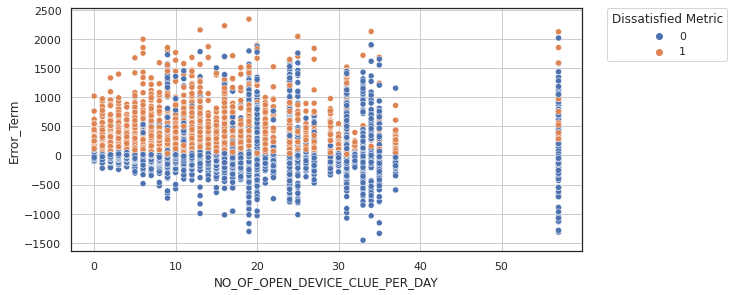

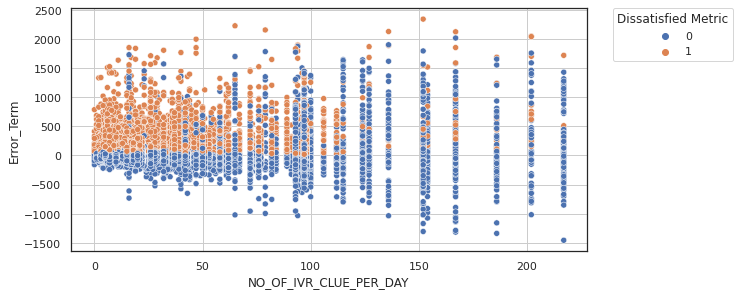

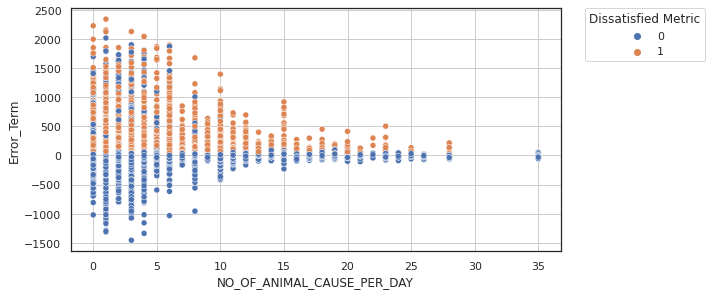

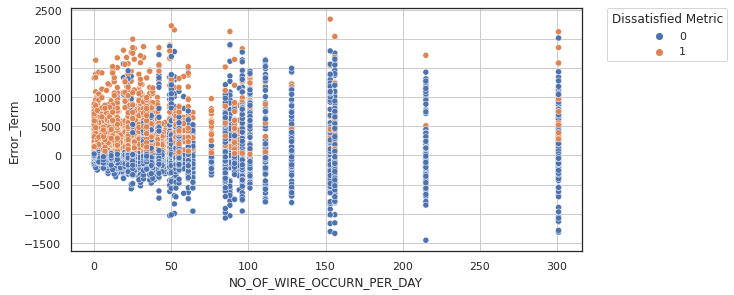

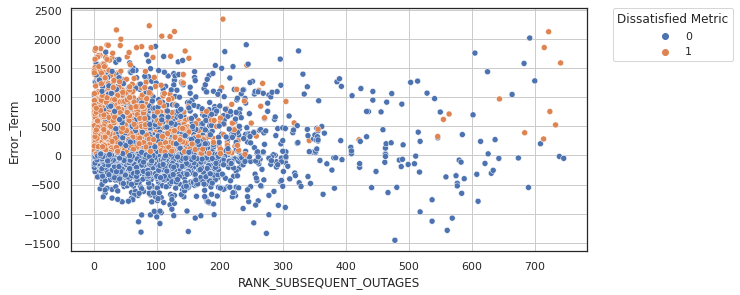

In [51]:
sns.set(rc={'figure.figsize':(26,20)})
sns.set_style("white")
for i, col in enumerate(list(df_copy[day_cause_occurn_clue_features].columns.values)):
    plt.subplot(5,3,i+1)
    sns.scatterplot(data=df_copy, x=col, y="Error_Term", hue='Dissatisfied')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Dissatisfied Metric')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [42]:
customer_features = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr',
                     'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr',
                     'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty']

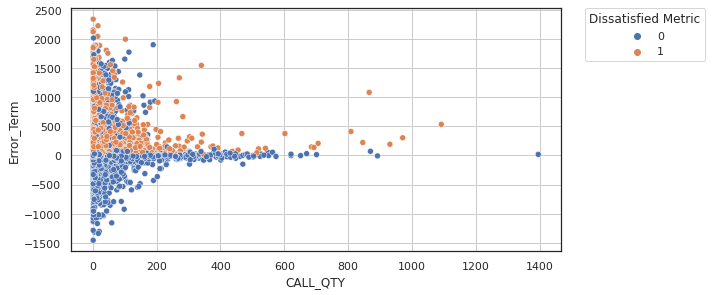

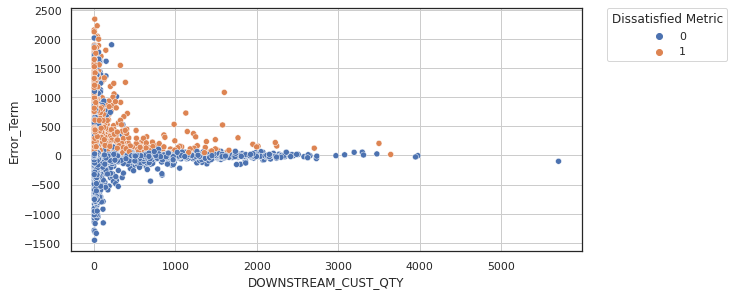

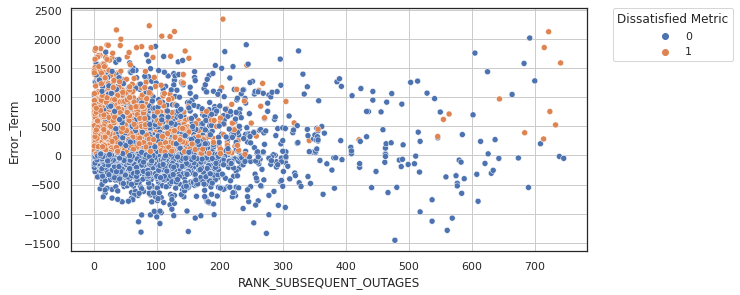

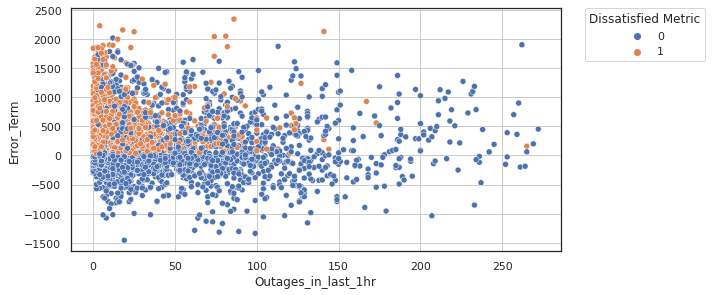

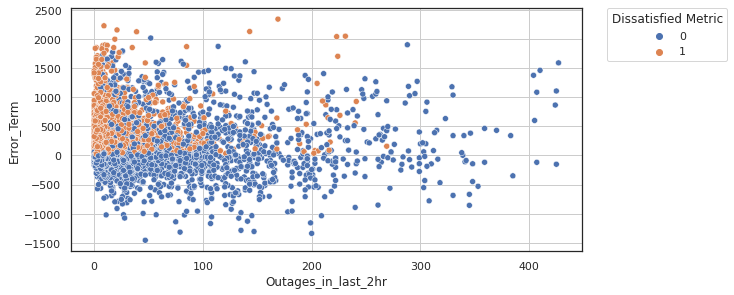

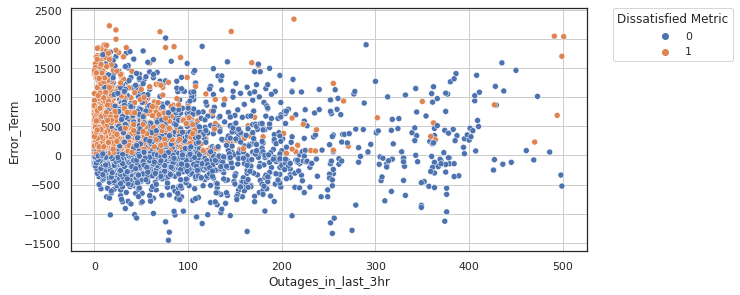

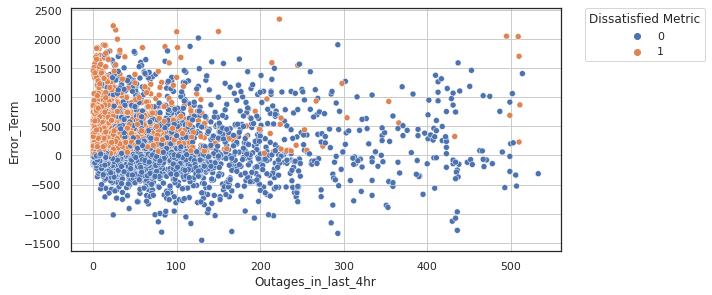

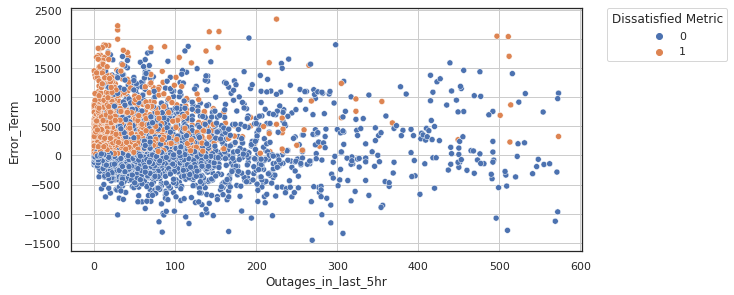

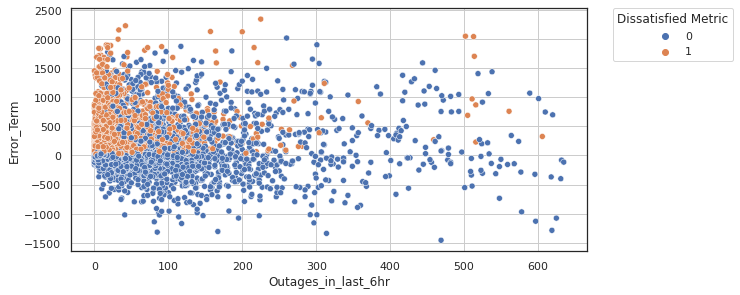

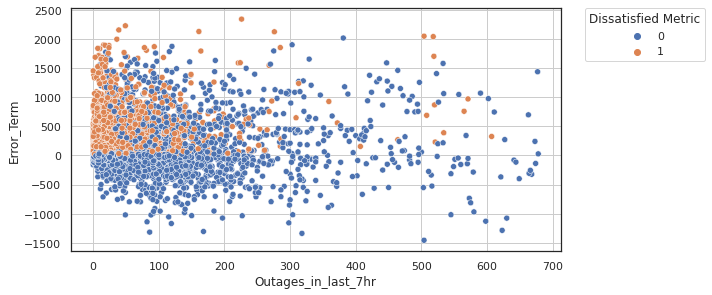

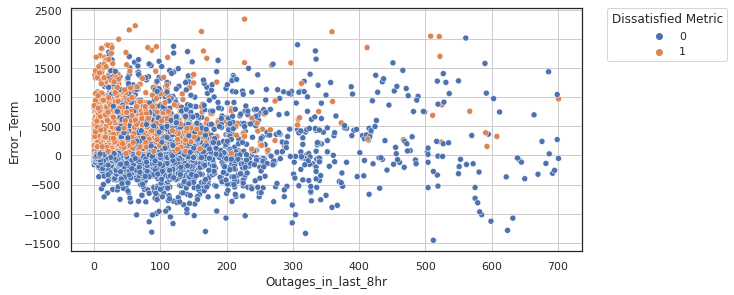

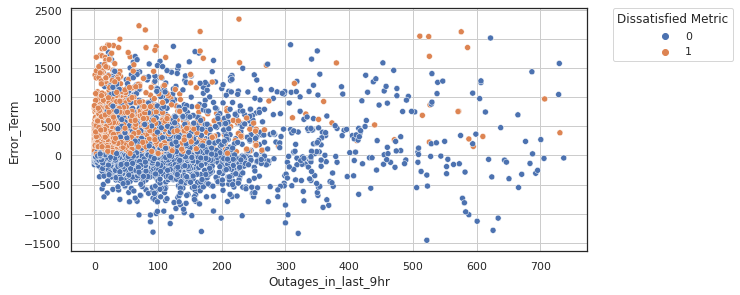

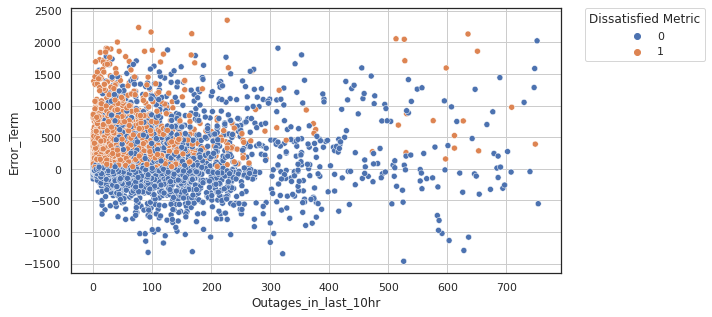

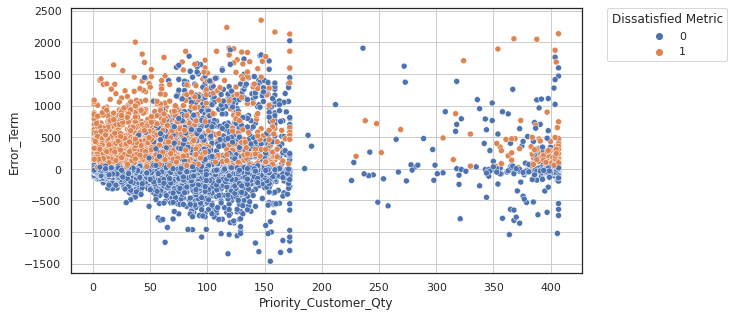

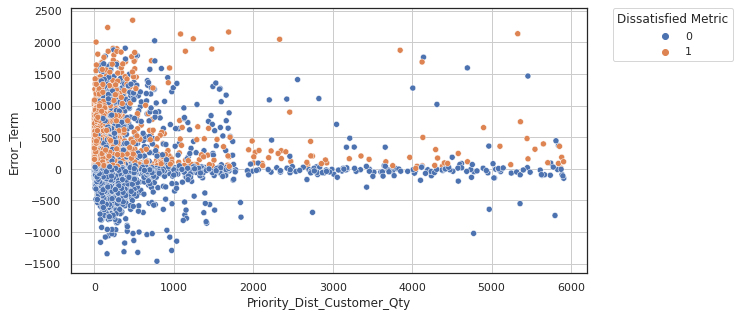

In [52]:
sns.set(rc={'figure.figsize':(26,20)})
sns.set_style("white")
for i, col in enumerate(list(df_copy[customer_features].columns.values)):
    plt.subplot(5,3,i+1)
    sns.scatterplot(data=df_copy, x=col , y='Error_Term', hue='Dissatisfied')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Dissatisfied Metric')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [32]:
dni_eqip_features = ['DNI_EQUIP_TYPE_1TBOH', 'DNI_EQUIP_TYPE_1TPUG', 'DNI_EQUIP_TYPE_2TBOD', 'DNI_EQUIP_TYPE_2TBPAR', 'DNI_EQUIP_TYPE_3TBOH',
                     'DNI_EQUIP_TYPE_3TPUG', 'DNI_EQUIP_TYPE_ASWITCH', 'DNI_EQUIP_TYPE_BPSWITCH', 'DNI_EQUIP_TYPE_CUT', 'DNI_EQUIP_TYPE_FPO',
                     'DNI_EQUIP_TYPE_FUSE', 'DNI_EQUIP_TYPE_OHPRIM', 'DNI_EQUIP_TYPE_PADELB', 'DNI_EQUIP_TYPE_PAR_SWITCH', 'DNI_EQUIP_TYPE_PO', 
                     'DNI_EQUIP_TYPE_RECL', 'DNI_EQUIP_TYPE_SB_FUSE', 'DNI_EQUIP_TYPE_SECTZ', 'DNI_EQUIP_TYPE_SSUB', 'DNI_EQUIP_TYPE_SW_GEAR', 
                     'DNI_EQUIP_TYPE_SWITCH', 'DNI_EQUIP_TYPE_TAPSWITCH', 'DNI_EQUIP_TYPE_TSWITCH', 'DNI_EQUIP_TYPE_UGPRIM', 'DNI_EQUIP_TYPE_USWITCH']

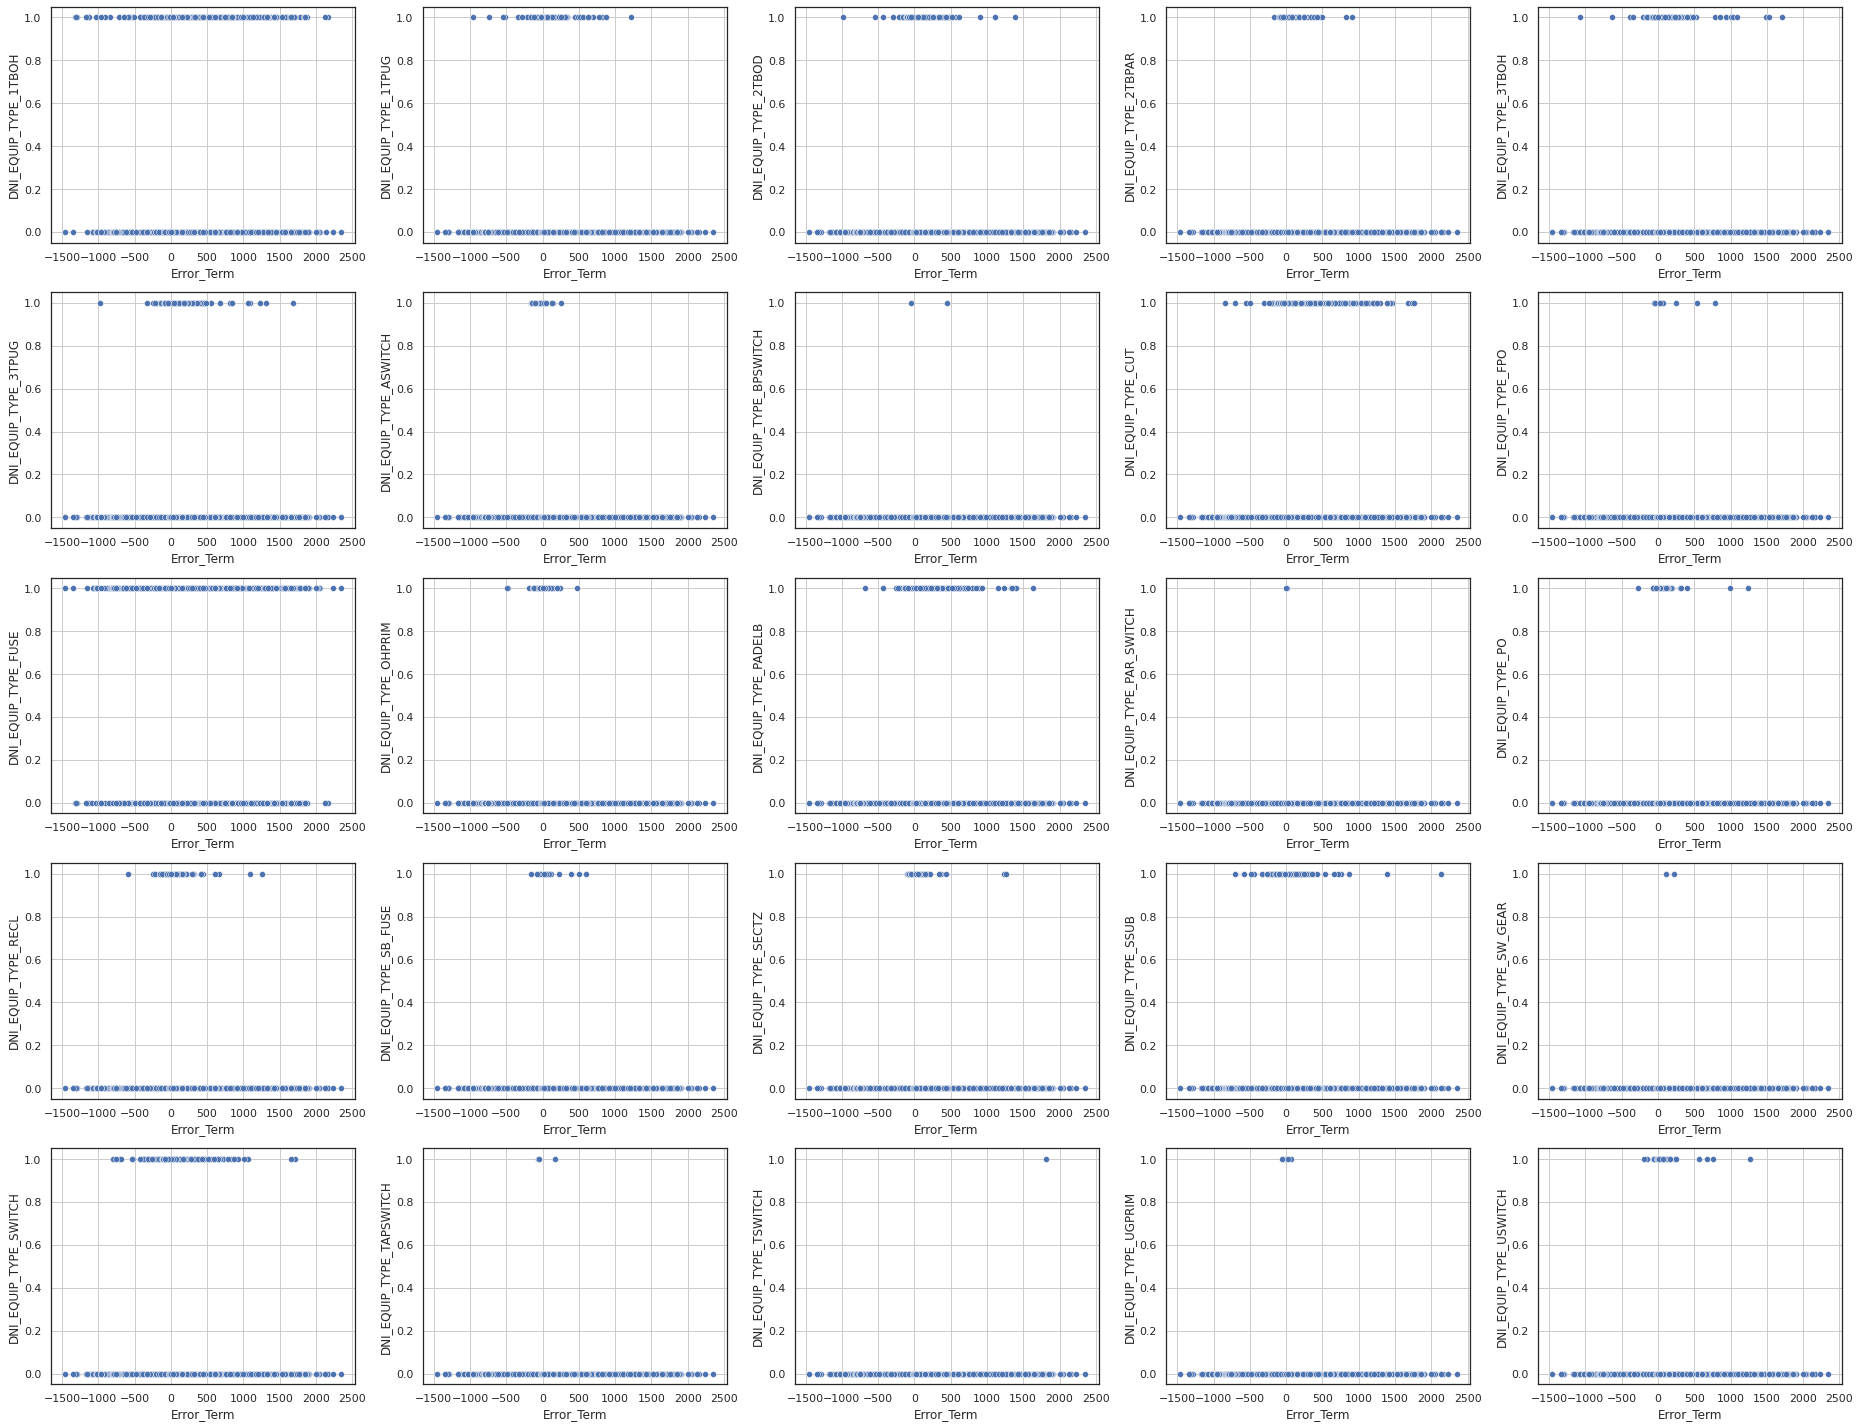

In [33]:
sns.set(rc={'figure.figsize':(26,20)})
sns.set_style("white")
for i, col in enumerate(list(df_copy[dni_eqip_features].columns.values)):
    plt.subplot(5,5,i+1)
    sns.scatterplot(data=df_copy, x="Error_Term", y=col)
    plt.grid()
    plt.tight_layout()

In [28]:
flag_features = ['OH_OCCURN_FLG_False', 'RECLOSER_OCCURN_FLG_False', 'CAP_BANK_OCCURN_FLG_False', 'CUTOUT_OCCURN_FLG_False', 'REGULATOR_OCCURN_FLG_False',
            'SWITCH_OCCURN_FLG_False', 'WIRE_OCCURN_FLG_False', 'PUBLIC_SAFETY_OCCURN_FLG_False', 'FOUND_OPEN_OCCURN_FLG_False', 'FIRE_OCCURN_FLG_False',
            'ST_OCCURN_FLG_False', 'CABLE_OCCURN_FLG_False', 'SERVICE_OCCURN_FLG_False', 'METER_OCCURN_FLG_False', 'TRANSFORMER_OCCURN_FLG_False',
            'POLE_OCCURN_FLG_False', 'CUST_EQUIP_OCCURN_FLG_False', 'FUSE_OCCURN_FLG_True', 'NO_OUTAGE_CAUSE_FLG_False', 'PLANNED_CAUSE_FLG_False',
            'NO_CAUSE_FLG_False', 'MISCELLANEOUS_CAUSE_FLG_False', 'TREE_CAUSE_FLG_False', 'SUBSTATION_CAUSE_FLG_False', 'STREET_CAUSE_FLG_False',
            'WEATHER__FLOOD_CAUSE_FLG_False', 'CUST_REQUEST_CAUSE_FLG_False', 'WEATHER__HEAT_CAUSE_FLG_False', 'WEATHER__WIND_CAUSE_FLG_False',
            'WEATHER__SNOW_CAUSE_FLG_False', 'WEATHER_LIGHTNING_CAUSE_FLG_False', 'PUBLIC_CAUSE_FLG_False', 'WEATHER_COLD_CAUSE_FLG_False',
            'WEATHER_CAUSE_FLG_False', 'ANIMAL_CAUSE_FLG_False', 'UG_CAUSE_FLG_False', 'OH_CAUSE_FLG_False', 'TRANSFORMER_CLUE_FLG_False',
            'EQUIPMENT_CLUE_FLG_False', 'IVR_CLUE_FLG_False', 'WIRE_DOWN_CLUE_FLG_False', 'TREE_CLUE_FLG_False', 'OPEN_DEVICE_CLUE_FLG_False',
            'POWER_OUT_CLUE_FLG_True', 'PART_LIGHT_CLUE_FLG_False', 'POLE_CLUE_FLG_False']

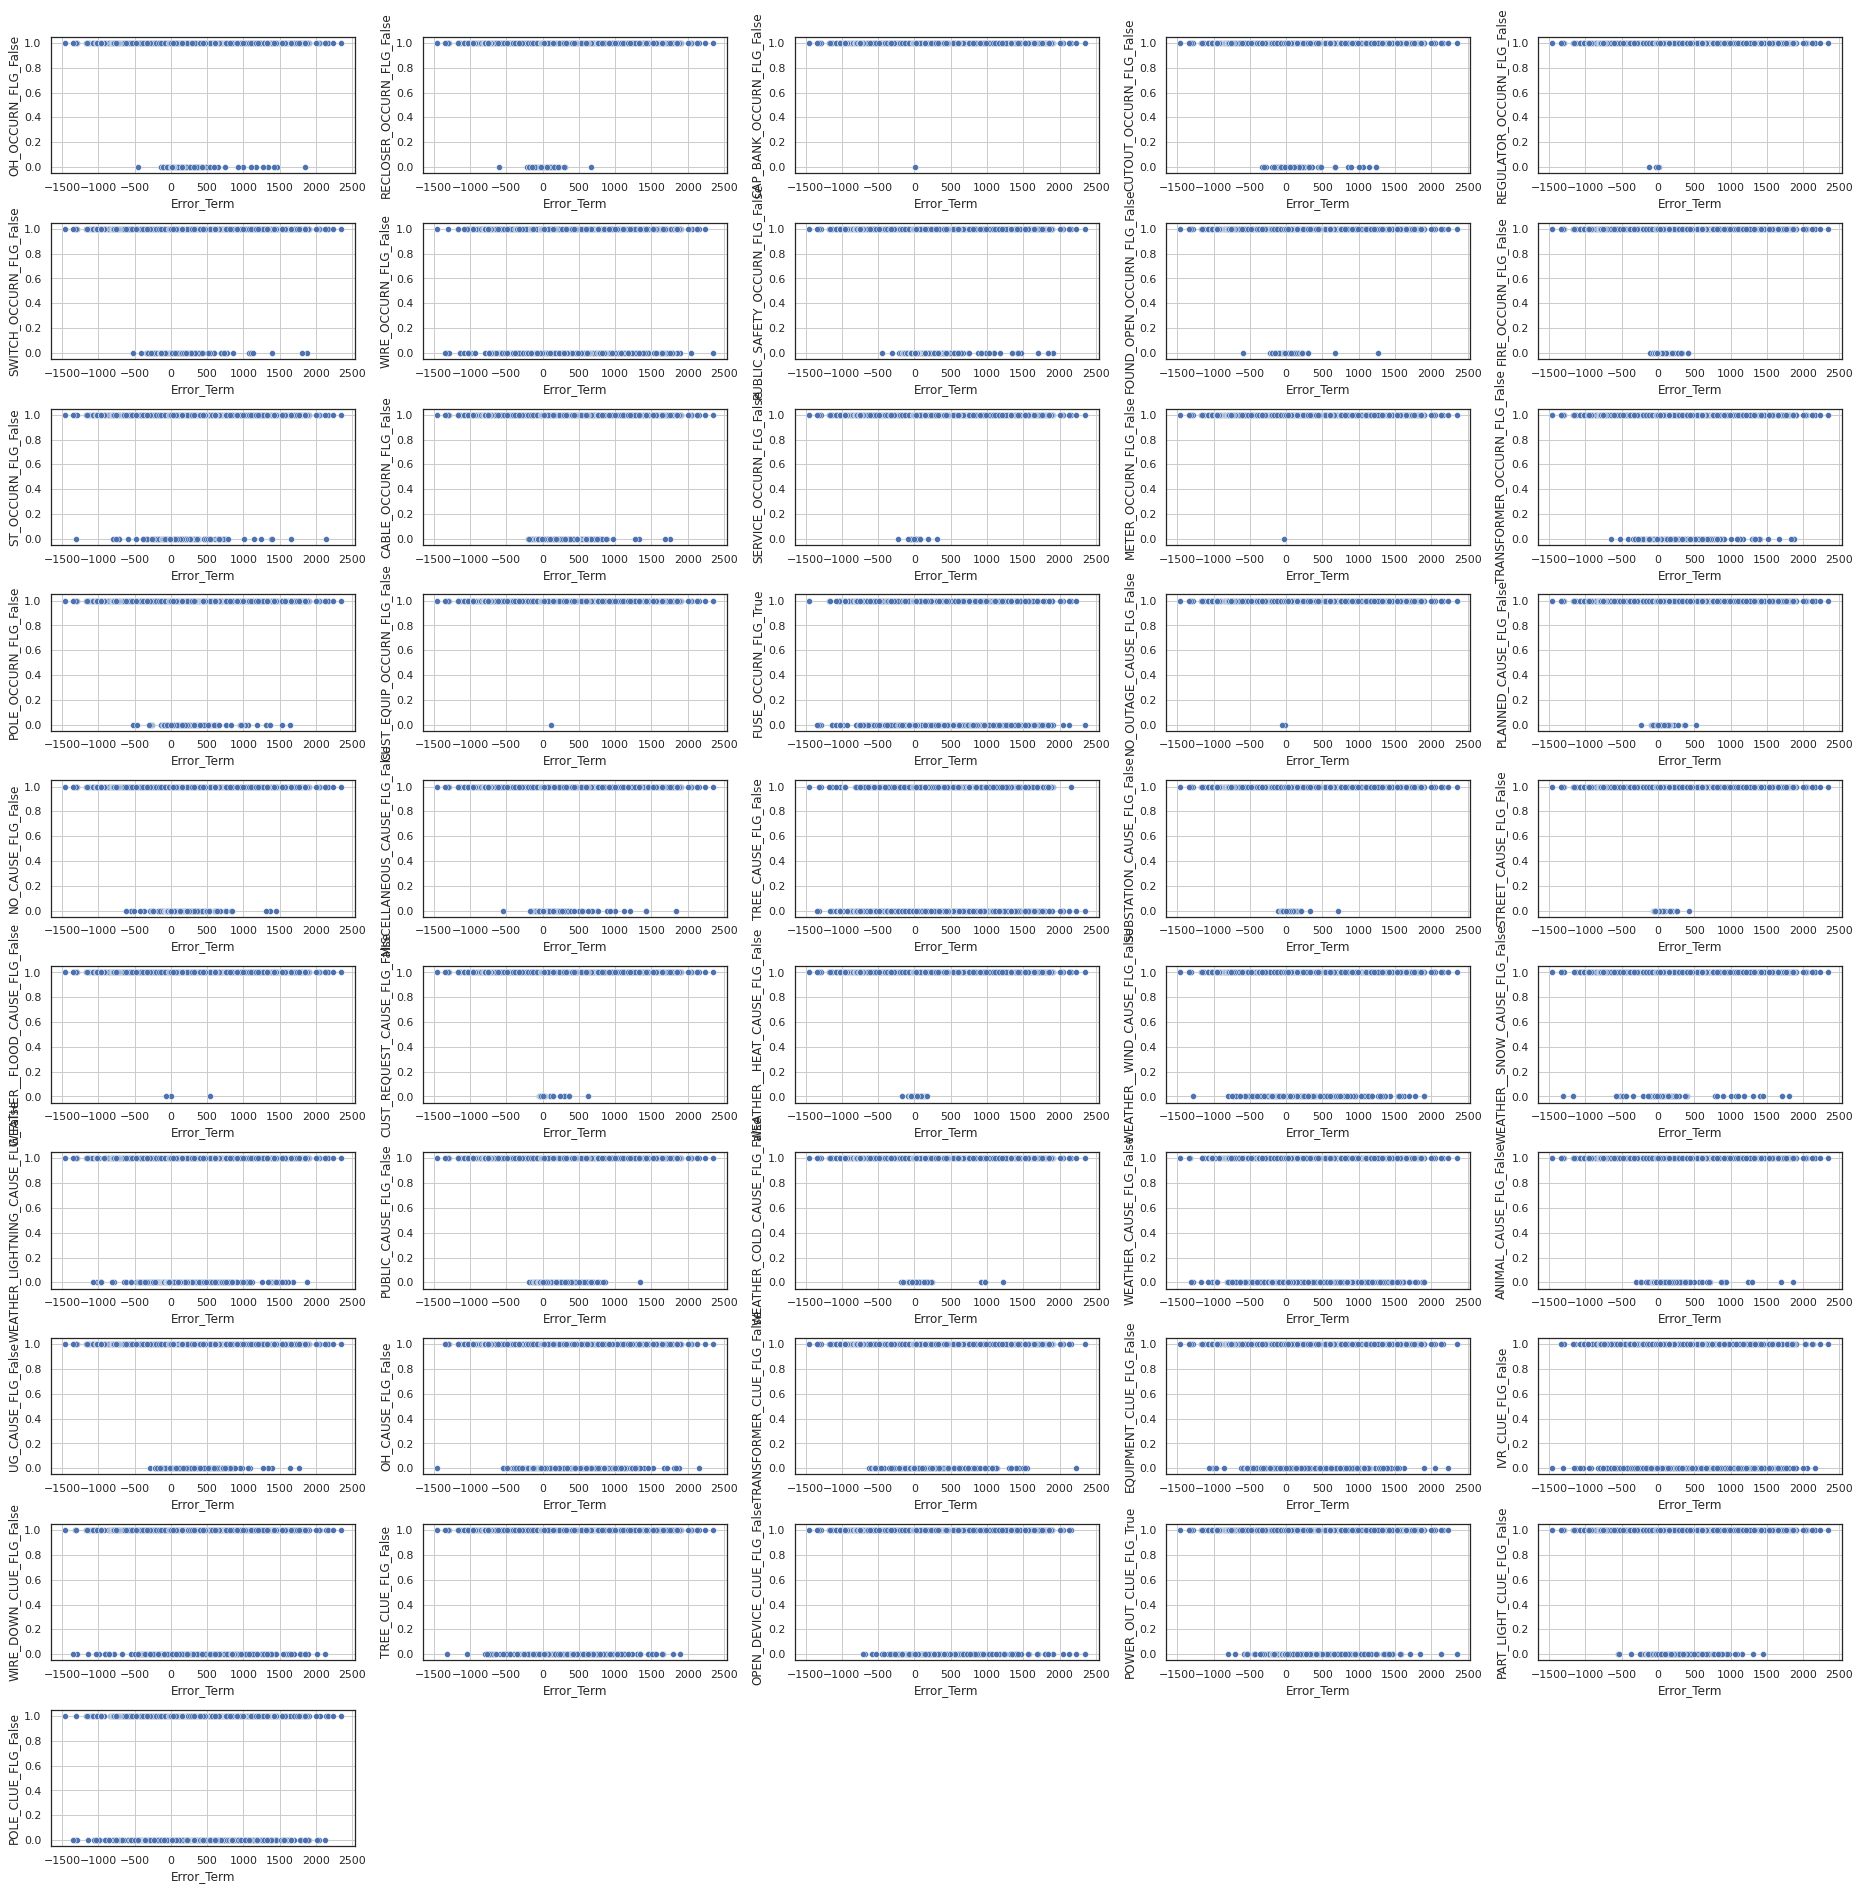

In [31]:
sns.set(rc={'figure.figsize':(26,26)})
sns.set_style("white")
for i, col in enumerate(list(df_copy[flag_features].columns.values)):
    plt.subplot(10,5,i+1)
    sns.scatterplot(data=df_copy, x="Error_Term", y=col)
    plt.grid()
    plt.tight_layout()

In [24]:
features = ['Dispatch_Location_34th', 'Dispatch_Location_ARL.', 'Dispatch_Location_ENGLISH', 'Dispatch_Location_MILL', 'Dispatch_Location_SOUTH']

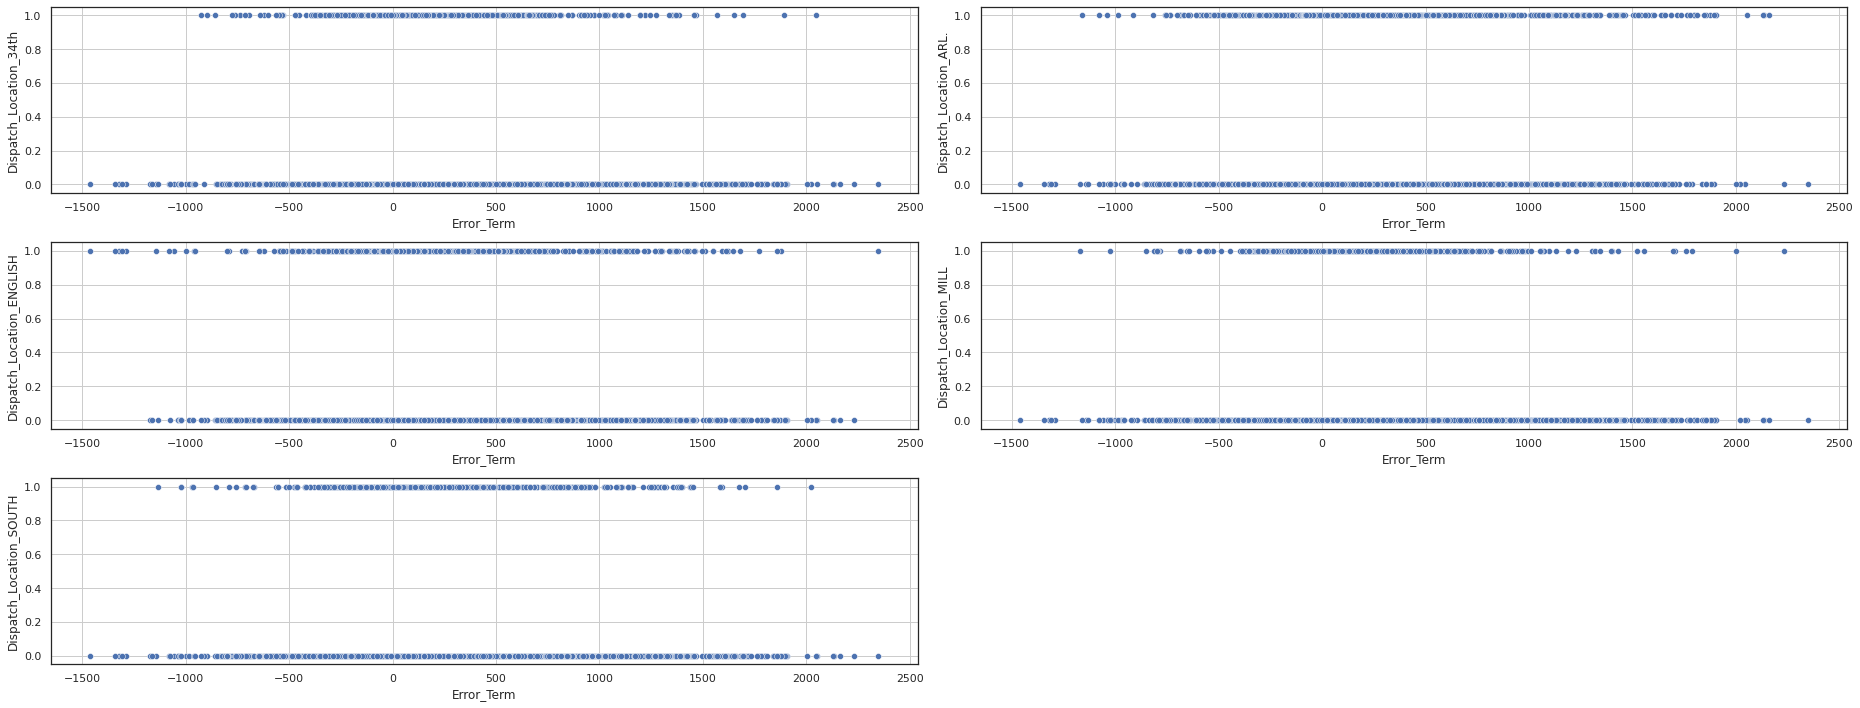

In [26]:
sns.set(rc={'figure.figsize':(26,10)})
sns.set_style("white")
for i, col in enumerate(list(df_copy[features].columns.values)):
    plt.subplot(3,2,i+1)
    sns.scatterplot(data=df_copy, x="Error_Term", y=col)
    plt.grid()
    plt.tight_layout()

#### **Pair Plot for dissatified outage metric**

In [13]:
# sns.pairplot(df_copy.sample(1000), hue="Dissatisfied")

#### **Bar plot for Seaborn Plots**

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_PLS", y="Features", data=pls_reg , palette = sns.diverging_palette(240, 10, n=9)).set_title('Feature Selection : PLS')

#### **Correlation Matrix**

In [ ]:
#whitegrid
sns.set_style('whitegrid')
#compute correlation matrix...
corr_matrix=df_copy.corr(method='spearman')
#...and show it with a heatmap
#first define the dimension
plt.figure(figsize=(26,26))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(round(corr_matrix,2), mask=mask, cmap=cmap, center=0, vmax=1, vmin =-1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

#### **Box Plot of selected variables**

In [18]:
df_copy.shape

(30711, 197)

KeyError: "None of [Index(['Actual_segment'], dtype='object')] are in the [columns]"

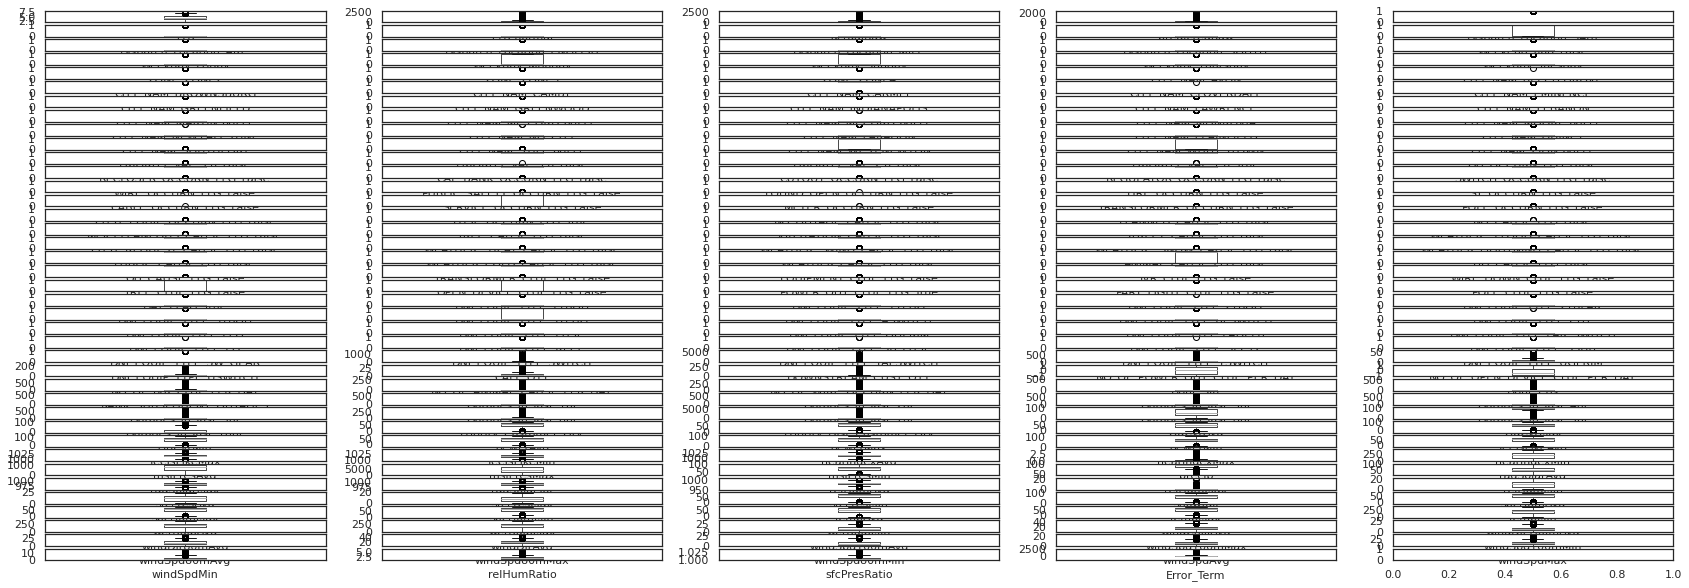

In [19]:
sns.set(rc={'figure.figsize':(26,26)})
sns.set_style("white")
for i, col in enumerate(list(df_copy.columns.values)):
    plt.subplot(100,5,i+1)
    df_copy.boxplot(col)
    plt.grid()
    plt.tight_layout()

#### **Distribution Plot of Variables**

In [ ]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(10,4,i+1)
    sns.distplot(ads_v1[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

In [ ]:
def flagging(row):
    if row > 0:
        return 0
    else :
        return 1
    
df_copy['flagging'] = df_copy.apply(lambda row: flagging(row['Error_Term']),axis=1)

In [ ]:
print(df_copy['flagging'].sum())
print(df_copy['flagging'].mean())

In [ ]:
df_copy['Negative_Error'] = df_copy['flagging'] * df_copy['Error_Term']

In [ ]:
df_copy['Error_Per'] = (df_copy['Negative_Error'] / df_copy['actualRaw'])*100.0

In [ ]:
df_copy['Error_Per'].min()

In [ ]:
df_copy['Predicted_Modified'] = (df_copy['predictedRaw'] + df_copy['predictedRaw'] * 0.45)

In [ ]:
df_copy[['actualRaw', 'Error_Term', 'predictedRaw', 'Predicted_Modified', 'Actual_segment', 'Prediction_segment', 'Dissatisfied', 'DOWNSTREAM_CUST_QTY', 'CALL_QTY']].head(20)